# Introduction

The aviation field is concerned with safety of airplanes and is doing their best to understand the reason for any potential incidents.  
In this mini-tutorial, suppose you are invited by the aviation authority to analyze all the history aviation incidents.  
Hopefully the results could help reveal potential problems, build more robust aircraft, and impose more effective regulation.  

In the meanwhile, you will learn a variety of data analytical tools, mostly Python-based, by applying them to real data extracted from the Web.

** This mini-tutorial is composed of three parts: **
1. Data extraction: scrape the website about aviation incidents.
2. Data cleaning: clean the extracted data by removing irrelevant information.
4. Entity recognition: use an entity extraction tool Koko, to extract entities from scraped data.
5. Data transformation: convert the unstructured text data into dataframes.

# 1. Data acquisition

To acquire data, we first need to scrape the text data about aviation incidents from the following Wiki page:  
https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft

A number of Python-based tools can be used to scrape the Web, such as [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) or [Scrapy](https://scrapy.org/).  
Here we use BeautifulSoup for our purpose.  
Suppose we already save the Wiki website as an HTML file. The following code create parse the html file and generate a BeautifulSoup object.

In [1]:
from bs4 import BeautifulSoup

input_html = "./data/aircraft_incidents.htm"
with open(input_html, "r") as ifile:
    soup = BeautifulSoup(ifile, 'lxml')
    
soup.title.string

'List of accidents and incidents involving commercial aircraft - Wikipedia'

**Task:** Use BeautifulSoup to scrape the Wiki website at https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft, and generate a text file containing all the text on the website. The generated file should not contain any html tag.

In [7]:
output_fname = "./data/aviation_incidents_raw_texts.txt"

# Write your code here. Store the output text in output_fname#

The following code will check if the generated text file satisfy the requirement.

In [8]:
import re

with open(fname, "r") as ifile:
    # Check if all tags have been removed
    doc = ifile.read()
    result = re.search(r"<.*>", doc)
    if result:
        print("Error: \n{}".format(result.string))
    else:
        print("No tag found!")

NameError: name 'fname' is not defined

# 2. Data Cleaning

You may notice that the extracted data is not very organized.  
Our next step is to clean the extracted data, so that it can be used for further analysis.

Here's a sample of how a cleaned version should look like:

In [4]:
with open('./data/aviation_incidents_cleaned.txt') as ifile:
    for i in range(5):
        print(ifile.readline())

July 21, 1919, The Goodyear dirigible Wingfoot Air Express catches fire and crashes into the Illinois Trust and Savings Building in Chicago, Illinois, while carrying passengers to a local amusement park, killing thirteen people: three out of the five on board and ten others on the ground, with 27 others on the ground being injured.

August 2, 1919, A Caproni Ca.48 crashes at Verona, Italy, during a flight from Venice to Taliedo, Milan, killing all on board (14, 15, or 17 people, according to different sources).

December 14, 1920, A Handley Page Transport Handley Page O/400 hits a tree and crashes at Golders Green, London, after failing to gain height following takeoff, killing four out of eight on board.

April 7, 1922, In the first mid-air collision of airliners, a de Havilland DH.18A, G-EAWO, operated by Daimler Hire Ltd., collides with a Farman F.60 Goliath, F-GEAD, operated by Compagnie des Grands Express Aériens (CGEA), over the Thieulloy-St. Antoine road near Picardie, France, k

There are a variety of ways to clean the documents. Here we give one example.  

* Extract the data that are related to aviation incidents.
* Clean the extracted data segment, by embedding the year information into each incident and removing em dashes that could cause trouble in follow-up analysis.

## Extract incident-related texts

In [5]:
with open('./data/aviation_incidents_raw_texts.txt') as ifile:
    with open('./data/aviation_incidents_select.txt', 'w+') as ofile:
        to_record = False
        for line in ifile:
            cleaned_line = line.rstrip()
            if not cleaned_line:
                continue
            
            if 'References' in line:
                break
                
            if 'See also' in line:
                to_record = True
                continue
        
            if to_record == True:
                ofile.write(line)        

Let's take a glimpse of the output file.

In [6]:
with open('./data/aviation_incidents_select.txt') as myfile:
    head = [next(myfile) for x in range(10)]
head

['1910s and 1920s[edit]\n',
 '1919[edit]\n',
 'July 21 – The Goodyear dirigible Wingfoot Air Express catches fire and crashes into the Illinois Trust and Savings Building in Chicago, Illinois, while carrying passengers to a local amusement park, killing thirteen people: three out of the five on board and ten others on the ground, with 27 others on the ground being injured.\n',
 'August 2 – A Caproni Ca.48 crashes at Verona, Italy, during a flight from Venice to Taliedo, Milan, killing all on board (14, 15, or 17 people, according to different sources).\n',
 '1920[edit]\n',
 'December 14 – A Handley Page Transport Handley Page O/400 hits a tree and crashes at Golders Green, London, after failing to gain height following takeoff, killing four out of eight on board.\n',
 '1922[edit]\n',
 'April 7 – In the first mid-air collision of airliners, a de Havilland DH.18A, G-EAWO, operated by Daimler Hire Ltd., collides with a Farman F.60 Goliath, F-GEAD, operated by Compagnie des Grands Express 

## Clean the extracted segment

Right now the year information is listed independently at the beginning of a series of incidents.  
Let's embedd each year into the follow-up incidents, to make each incident more informative.

For example, if we have:  
* "1920\[edit\]:  
December 14 – A Handley Page Transport Handley Page O/400 hits a tree and crashes at Golders Green, London, after failing to gain height following takeoff, killing four out of eight on board." *

We will remove "1920\[edit\]:", and add "1920" as part of the incident, to have:

* "On December 14, 1920 – A Handley Page Transport Handley Page O/400 hits a tree and crashes at Golders Green, London, after failing to gain height following takeoff, killing four out of eight on board."  *

In [7]:
def represent_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

with open('./data/aviation_incidents_select.txt' ) as ifile:
     with open('./data/aviation_incidents_cleaned.txt', 'w') as ofile:
        year = 0
        for line in ifile:
            cleaned_line = line.replace('[edit]', '')
            proc_line = cleaned_line.rstrip()
            if represent_int(proc_line):
                # The line represents a year
                year = int(proc_line)
                continue
            else:
                months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                          'August', 'September', 'October', 'November', 'December']
                month_pattern = '|'.join(months)
                if re.search(month_pattern, proc_line):
                    match_obj = re.search(r"[0-9]\s.\s", proc_line)
                    if match_obj:
                        replace_text = ", " + str(year) + ", "
                        newline = proc_line.replace(match_obj.group()[1:], replace_text)
                        ofile.write(newline+'\n')

Let's take a look at the results.

In [10]:
with open('./data/aviation_incidents_cleaned.txt') as myfile:
    head = [next(myfile) for x in range(5)]
head

['July 21, 1919, The Goodyear dirigible Wingfoot Air Express catches fire and crashes into the Illinois Trust and Savings Building in Chicago, Illinois, while carrying passengers to a local amusement park, killing thirteen people: three out of the five on board and ten others on the ground, with 27 others on the ground being injured.\n',
 'August 2, 1919, A Caproni Ca.48 crashes at Verona, Italy, during a flight from Venice to Taliedo, Milan, killing all on board (14, 15, or 17 people, according to different sources).\n',
 'December 14, 1920, A Handley Page Transport Handley Page O/400 hits a tree and crashes at Golders Green, London, after failing to gain height following takeoff, killing four out of eight on board.\n',
 'April 7, 1922, In the first mid-air collision of airliners, a de Havilland DH.18A, G-EAWO, operated by Daimler Hire Ltd., collides with a Farman F.60 Goliath, F-GEAD, operated by Compagnie des Grands Express Aériens (CGEA), over the Thieulloy-St. Antoine road near Pi

# 3. Entity recognition

Now we are ready to extract interesting and useful information from the cleaned corpus.  

We first create a word cloud as warm-up exercise, and get a general sense of the distribution of words in the corpus.  
Then we will use Koko, an entity extraction tool, to extract airlines and aircrafts from the corpus.

## Word Cloud

The following code generates a wordcloud out of the cleaned corpus.  

Note that we remove common aviation-related words, such as airlines or flight, as they are less informative.

(-0.5, 3599.5, 2699.5, -0.5)

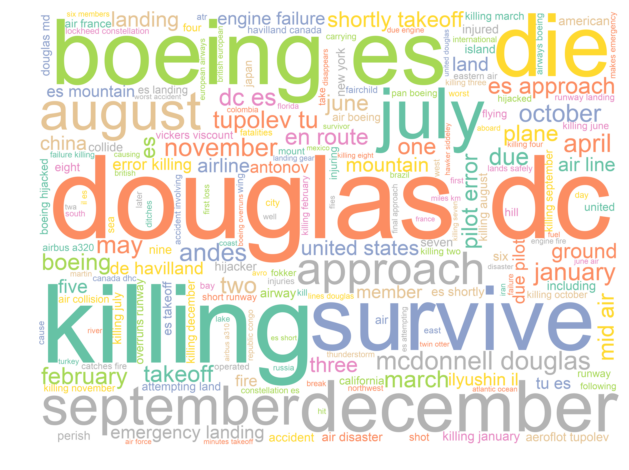

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

LIMIT_WORDS = ['airlines flight', 'flight', 'people', 'board', 'international airport', 
               'passenger', 'crew', 'airport', 'aircraft', 'near', 'crash', 'killed']

with open('./data/aviation_incidents_cleaned.txt') as myfile:
    doc = myfile.read()
text = doc.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", font_path='../../../Library/Fonts/Arial.ttf', \
                          height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

What conclusion can you get from the wordcloud?

## Named Entity Extration

Now suppose we are interested in knowing which airline company has the most incidents.  
How can we get the information from the corpus?  

There are a number of Python-based tools that can extract entities like airline names from text, such as [NLTK](http://www.nltk.org/), [spaCy](https://spacy.io/), [Google NLP](https://cloud.google.com/natural-language/).  
Though these tools are powerful, they do not provide declarative APIs that allow users to extract entities with customed conditions.  
Here we will introduce an entity extraction framework called Koko, which allows the user to specify properties of the extracted entities in a declarative way, and is especially suitable for extracting entities with little evidence in the corpus.

In [11]:
with open('./koko_queries/airlines_v2.koko', 'r') as file:
    print(file.read())

extract "Ents" x from "/Users/chen/Research/Code/BigGorilla-assignments/Koko/data/aviation_incidents_cleaned.txt" if
	(str(x) contains "Airlines" {0.1}) or
	(str(x) contains "Air" {0.1})
with threshold 0.0



This query tells Koko to extract noun phrases 'x' from HappyDB if "x" is preceded by either "buy" or "purchase".

The weight in each "if" condition (e.g., {0.1} for ("buy" x)) represents the importance of the pattern specified in the condition.
Any appearance of an entity in happy moments that matches the pattern is considered a piece of evidence.
And each such piece of evidence would increment the entity's score by the condition's weight.

For example, if there's a happy moment "I buy a car", this moment is considered as evidence for "a car" based on the first condition, and 0.1 is added to "a car"'s score.
In Koko, the score of an entity is at most 1.

Finally, we can specify threshold in Koko queries.
Only entities scoring higher than the thresold would be returned in the results.
For simplicity, I put zero as thresold here, which shows all entities that have at least one piece of evidence in happy moments.

If you are interested, check out more tutorials for Koko [here](http://pykoko.readthedocs.io/en/latest/).

Let's run the Koko query now to see the results.

Here I use spaCy as the nlp processor for happy moments. Koko could leverage spaCy's APIs for entity extraction.
The extracted entities could be further matched against the conditions in the Koko query to get scored, ranked and filtered.

SpaCy is not the only option. We can also use Koko's default parser or Google NLP API as well.

In [12]:
import koko
import spacy

koko.run('./koko_queries/airlines_v2.koko', doc_parser='spacy')

Parsed query: extract "/Users/chen/Research/Code/BigGorilla-assignments/Koko/data/aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.10 }) or
	(str(x) contains "Air" { 0.10 })   
with threshold 0.00


Results:

Entity name                    Entity count         Entity score
United Airlines                27                   1.000000
American Airlines              25                   1.000000
Northwest Airlines             11                   1.000000
Eastern Air Lines              16                   1.000000
Air France                     15                   1.000000
Japan Airlines                 11                   1.000000
China Airlines                 11                   1.000000
National Airlines              7                    0.700000
Northwest Orient Airlines      7                    0.700000
Philippine Airlines            7                    0.700000
Indian Airlines                7                    0.700000
Merpati Nusantara Airl

If we only want to see the top few results, we can set up threshold.

In [13]:
koko.run('./koko_queries/airlines_v3.koko', doc_parser='spacy')

Parsed query: extract "/Users/chen/Research/Code/BigGorilla-assignments/Koko/data/aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.10 }) or
	(str(x) contains "Air" { 0.10 })   
with threshold 0.40


Results:

Entity name                    Entity count         Entity score
United Airlines                27                   1.000000
American Airlines              25                   1.000000
Northwest Airlines             11                   1.000000
Eastern Air Lines              16                   1.000000
Air France                     15                   1.000000
Japan Airlines                 11                   1.000000
China Airlines                 11                   1.000000
National Airlines              7                    0.700000
Northwest Orient Airlines      7                    0.700000
Philippine Airlines            7                    0.700000
Indian Airlines                7                    0.700000
Merpati Nusantara Airl

We can also see the original texts.import koko
import spacy

koko.run('./koko_queries/airlines_v2.koko', doc_parser='spacy')

In [14]:
koko.run('./koko_queries/airlines_v4.koko', doc_parser='spacy', verbose_info=True)

Parsed query: extract "/Users/chen/Research/Code/BigGorilla-assignments/Koko/data/aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.01 }) or
	(str(x) contains "Air" { 0.01 })   
with threshold 0.26


Results:

Entity name                    Entity count         Entity score
United Airlines                27                   0.270000
	 October 7, 1935, United Airlines Trip 4, a Boeing 247D, crashes near Silver Crown, Wyoming, United States, due to pilot error; all 12 on board die.
 

	 December 27, 1936, United Airlines Trip 34, a Boeing 247, crashes at Rice Canyon (near Newhall, California, United States) due to pilot error, killing all 12 on board.
 

	 May 29, 1947, United Airlines Flight 521, a Douglas DC-4, crashes on takeoff from LaGuardia Airport, New York, United States, due to pilot error; 42 of 48 on board die.
 

	 October 24, 1947, United Airlines Flight 608, a Douglas DC-6, crashes near Bryce Canyon Airport, Utah, United States, when fire ca

**Task 2:** Find the models of aircrafts that have most incidents in the corpus.

# 3. Data transformation

Text data are not structured. To facilitate further data processing, it would be better if we convert text into more structured data, such as Dataframes.  

Here we use textual data instead of JSON output of Koko, because Koko's response doesn't include the original texts, but only the sentence ID of the matching sentences.

# From text to Dataframe

We use spaCy and pandas to convert text data into Dataframe.

We need the list of all aircrafts to sift through the extraction results.  

https://en.wikipedia.org/wiki/List_of_aircraft_by_date_and_usage_category

In [5]:
import pandas as pd
import spacy
import re

nlp = spacy.load('en')

df = pd.DataFrame(columns=['Date', 'Airline', 'Aircraft', 'Location'])
# We could add the field of 'Aircraft'. But that could be tricky.

incidents = []
with open('./data/aviation_incidents_cleaned.txt') as myfile:
    for line in myfile:
        doc = nlp(line)
        icd = {'Date':'', 'Airline':'', 'Flight':'', 'Location':''}
        for ent in doc.ents:
            if ent.label_ == u'DATE':
                # Get the date
                icd['Date'] = ent.text
            elif ent.label_ == u'ORG':
                # Get the organization
                icd['Airline'] = ent.text                
            elif ent.label_ == u'PRODUCT':
                # Get the flight number
                if re.search(r'flight', ent.text, re.I):
                    icd['Flight'] = ent.text
            elif ent.label_ == u'GPE':
                # Get the location
                icd['Location'] += '' + ent.text
        incidents.append(icd)

df = pd.DataFrame(incidents)
df.head

<bound method NDFrame.head of                                       Airline                Date  \
0     the Illinois Trust and Savings Building      July 21, 1919,   
1                               Caproni Ca.48     August 2, 1919,   
2                               Golders Green   December 14, 1920   
3                                   Thieulloy      April 7, 1922,   
4                                An Air Union        May 14, 1923   
5                               Kent, England     August 27, 1923   
6                   Ivinghoe, Buckinghamshire  September 14, 1923   
7            An Imperial Airways de Havilland  December 24, 1924,   
8                                College Farm         a day later   
9                        An Air Union Blériot     October 2, 1926   
10                              Kent, England     August 22, 1927   
11                           Imperial Airways      July 13, 1928,   
12                           Imperial Airways       June 17, 1929   
13  

** Task **: Extract models of aircrafts and add them into the dataframe.
You can use the following website for reference of aircraft models: 
https://en.wikipedia.org/wiki/List_of_aircraft_by_date_and_usage_category

# Follow-up processing:

- Entity matching: for example, merge different "Air France".
- Schema matching: merge with other aviation data.

# Back-up cells

In [1]:
from bs4 import BeautifulSoup

input_html = "./data/aircrafts.htm"
with open(input_html, "r") as ifile:
    soup = BeautifulSoup(ifile, 'lxml')
    with open('aircrafts_raw.txt', "w") as ofile:
        ofile.write(soup.get_text())